In [433]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import operator
import xgboost as xgb
from collections import defaultdict
import numpy as np
from sklearn.utils import shuffle

In [3]:
train = pd.read_csv("train.csv")

In [4]:
test = pd.read_csv("test.csv")

In [5]:
# removing features with only one unique value

def get_feats_with_unique(data):
    unique_counts = data.nunique(axis=0)
    feats_with_unique = unique_counts[unique_counts==1].index
    return feats_with_unique

train_unique_feats = get_feats_with_unique(train)
train.drop(columns=train_unique_feats, inplace=True)

test.drop(columns=train_unique_feats, inplace=True)

In [6]:
# removing correlated features 

corr_mat = train.corr()

similar_feats = defaultdict(lambda: list)
for c in train.columns:
    corr_values = corr_mat[c]
    corr_feats = list(corr_values.index[(corr_values > 0.98) | (corr_values < -0.98)])
    sim_feats = list(set(corr_feats) - set([c]))
    if len(sim_feats)> 0:
        similar_feats[c] = sim_feats
    
similar_feats_cnt = defaultdict()
for k,v in similar_feats.items():
    similar_feats_cnt[k] = len(v)

sorted_feats_corr = sorted(similar_feats_cnt.items(), key = operator.itemgetter(1), reverse=True)

feats_to_delete = []
for t in sorted_feats_corr:
    feat = t[0]
    if len(list(set(similar_feats[feat]) - set(feats_to_delete))) > 0:
        feats_to_delete.append(feat)

In [289]:
len(feats_to_delete)

102

In [53]:
train.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


# Transform features

In [ ]:
# 1. Limiting the test values to max-min from train
# 2. Log of certain features
# 3.1. Normalize the values before PCA
# 3.2. PCA - perform PCA and get two eigen vectors
# 4. Converting categorical to one-hot

In [82]:
# 1. Limiting the test values to max-min from train
train_describe = train.describe()
test_describe = test.describe()
for c in train.columns:
    min_cut = train_describe[c]['min']
    max_cut = train_describe[c]['max']
    
    if test_describe[c]['min'] < min_cut:
        test.loc[test[c] < min_cut, c] = min_cut
        
    if test_describe[c]['max'] > max_cut:
        test.loc[test[c] > max_cut, c] = max_cut


In [122]:
# 2. Log of certain features

train_var = ((train_describe.loc['max'] - train_describe.loc['50%']))

features_log_transform = train_var.index[train_var>1e6]

train_transform = train.copy()

for c in features_log_transform:
    min_val = train_transform[c].min()
    add_val = 0
    if min_val < 0.01:
        add_val = 0.01 - min_val
    train_transform[c] = np.log(train_transform[c] + add_val)

In [128]:
test_transform = test.copy()

for c in features_log_transform:
    min_val = test_transform[c].min()
    add_val = 0
    if min_val < 0.01:
        add_val = 0.01 - min_val
    test_transform[c] = np.log(test_transform[c] + add_val)

In [123]:
# 3.1 Normalize values before PCA
from sklearn.preprocessing import Normalizer

In [124]:
normalizer = Normalizer()

In [130]:
train_transform_x = train_transform.drop(['TARGET'], axis=1)

In [156]:
train_transform_x.shape

(76020, 336)

In [131]:
train_transform_y = train_transform['TARGET']

In [132]:
normalizer.fit(train_transform_x)

Normalizer(copy=True, norm='l2')

In [133]:
train_transform_x = normalizer.transform(train_transform_x)

In [159]:
test_transform.drop(['TARGET'], axis=1, inplace=True)
test_transform_x = normalizer.transform(test_transform)

In [138]:
# 1. PCA
from sklearn.decomposition import PCA

In [139]:
pca = PCA(n_components=10)

In [140]:
pca_train = pca.fit(train_transform_x)

In [141]:
pca_train_feats = pca_train.transform(train_transform_x)

In [146]:
pca_feats = pd.DataFrame(pca_train_feats[:, :3], columns=['pca_1', 'pca_2', 'pca_3'])

In [162]:
train_transform_pca = pd.concat([train_transform, pca_feats], axis=1)

In [163]:
pca_test_feats = pca_train.transform(test_transform_x)

In [166]:
pca_feats_test = pd.DataFrame(pca_test_feats[:, :3], columns=['pca_1', 'pca_2', 'pca_3'])

In [169]:
test_transform_pca = pd.concat([test_transform, pca_feats_test], axis=1)

# Delete features

In [ ]:
# 1. Get feature selection (importances or scikit) and delete one-by-one
# 2. Delete highly correlated features
# 3. Delete features with no variance
# 4. Transform and delete

In [ ]:
# 1. Feature Selection

In [228]:
model = xgb.XGBClassifier(learning_rate=0.02, subsample=0.7, colsample_bytree=0.6)
bst_model = model.fit(train_transform_pca_x, train_transform_pca_y)

feat_importances2 = pd.DataFrame([train_transform_pca_x.columns, 
                                  bst_model.feature_importances_]).T.sort_values([1], ascending=False)


delete_features_xgb = feat_importances2[feat_importances2[1]<0.001][0].values

In [435]:
feat_importances2[1]

64

In [232]:
sorted_thresholds = np.sort(feat_importances2[1].unique())

In [235]:
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SelectFromModel

In [244]:
preds[:, 1]

array([0.11601725, 0.09081077, 0.07708313, ..., 0.07703704, 0.07746899,
       0.18143079], dtype=float32)

In [245]:
for thresh in sorted_thresholds:
    select_from_model = SelectFromModel(bst_model, threshold=thresh, prefit=True)
    train_x_subset = select_from_model.transform(train_transform_pca_x)
    
    xgb_classifier = xgb.XGBClassifier(learning_rate=0.02, nthread=4, colsample_bytree=0.6, subsample=0.7)
    xgb_model = xgb_classifier.fit(train_x_subset, train_transform_pca_y)
    
    preds = xgb_model.predict_proba(train_x_subset)
    auc_score = roc_auc_score(train_transform_pca_y.values, preds[:, 1])
    print ("Thresh {0} number of features {1} auc score {2}".format(thresh, train_x_subset.shape[1], auc_score))

Thresh 0.0 number of features 339 auc score 0.8241247945725331
Thresh 0.00022357383568305522 number of features 64 auc score 0.8296537763101606
Thresh 0.00040235143387690187 number of features 63 auc score 0.8292333229833394
Thresh 0.0009586086380295455 number of features 62 auc score 0.829357555694721
Thresh 0.001010045874863863 number of features 61 auc score 0.8247328218088019
Thresh 0.0017432220047339797 number of features 60 auc score 0.8299428687072425
Thresh 0.0017609683563932776 number of features 59 auc score 0.8294662365505933
Thresh 0.001807938446290791 number of features 58 auc score 0.8255301190652427
Thresh 0.0018319886876270175 number of features 57 auc score 0.8293635637970034
Thresh 0.0018620851915329695 number of features 56 auc score 0.8292015066781502
Thresh 0.0020088108722120523 number of features 55 auc score 0.8273032241093274
Thresh 0.0023577427491545677 number of features 54 auc score 0.8236322872748403
Thresh 0.0024268978741019964 number of features 53 auc sco

In [248]:
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.feature_selection import GenericUnivariateSelect

In [285]:
feature_select = GenericUnivariateSelect(mutual_info_classif, mode='k_best', param=60)

In [286]:
feature_select.fit(train_transform_pca_x.to_numpy(), train_transform_pca_y)

GenericUnivariateSelect(mode='k_best', param=60,
                        score_func=<function mutual_info_classif at 0x12fc09378>)

In [272]:
np.where(feature_select.get_support()==True)

(array([  2,  13,  15,  16,  18,  22,  23,  26,  27,  28,  29,  30,  31,
         32,  37,  47,  48,  58,  71,  74,  80,  81,  82,  85,  86,  87,
         88,  89,  90,  91,  96, 105, 106, 125, 126, 135, 139, 142, 145,
        152, 153, 156, 161, 165, 172, 174, 236, 249, 253, 254, 255, 256,
        297, 304, 306, 307, 310, 311, 335, 336]),)

In [287]:
selected_feats = train_transform_pca_x.columns[feature_select.get_support()]

In [264]:
np.argsort(feature_select.pvalues_)[::-1]

array([  3, 136, 210, 114, 243, 129, 130,   7,  62,  63,  19, 167, 195,
       183, 224, 324, 216, 214, 277, 279, 289, 199, 187, 201, 202, 194,
       182, 155, 317, 225, 318, 169, 219, 292, 284, 325, 209, 220, 164,
       150, 316, 323, 159, 258, 134, 133,  56,  25,  36, 124,  35,  43,
        67,  42,  66,  84,  94,  95, 101, 102, 175, 176, 221, 295, 206,
       112, 228, 326, 116, 223, 290, 178, 190, 198, 186, 242, 227, 184,
       196, 100, 180, 120, 191, 192, 113, 266, 286, 285, 197, 185, 276,
       193, 181, 288, 260,  20, 179, 208, 137, 138, 213,  72, 222, 287,
       241, 252,  24, 123,  83,  55,  99,  78, 267, 160, 173, 140, 281,
       328, 212, 211,  68, 332,  61, 207, 248, 320, 303, 238, 111, 334,
       301,  10, 333, 240,   6,   0, 329, 331, 168,  70,  69, 189, 177,
       302, 330, 291, 205,   5, 265, 327, 245,  97, 338, 235, 151, 244,
        12, 158,  41, 239, 128, 157, 271, 322,   1, 170, 321, 188, 200,
       226, 261, 132, 300, 264, 127,  77, 147, 163,  65, 162, 13

In [282]:
selected_feats_xgb = feat_importances2.iloc[:60][0].values

In [292]:
len(set(selected_feats_xgb) - set(feats_to_delete))

51

In [294]:
len(set(feats_to_delete) & set(selected_feats_xgb))

9

In [295]:
len(selected_feats_xgb)

60

# Add features

In [ ]:
# 1. Add missing feature to indicate missing elements
# 2. Add number of zeros in each row
# 3. Perform EDA

In [308]:
train_sub = pd.concat([train.loc[:,selected_feats_xgb], train['TARGET']], axis=1)

In [388]:
test_sub = test.loc[:, selected_feats_xgb]

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [397]:
train_sub_x = train_sub.drop(['TARGET'], axis=1)
train_y = train_sub['TARGET']

In [398]:
# adding zeros per row
train_sub_x["n_zeros"] = (train_sub_x==0).sum(axis=1)

In [389]:
test_sub["n_zeros"] = (test_sub==0).sum(axis=1)

In [315]:
pd.set_option('display.max_columns', 100)

In [334]:
train_sub.drop(['pca_1', 'pca_2', 'pca_3'], axis=1, inplace=True)

In [390]:
test_sub.drop(['pca_1', 'pca_2', 'pca_3'], axis=1, inplace=True)

In [340]:
train_sub = pd.concat([train_sub, train_transform_pca[['pca_1', 'pca_2', 'pca_3']]], axis=1)

In [391]:
test_sub = pd.concat([test_sub, test_transform_pca[['pca_1', 'pca_2', 'pca_3']]], axis=1)

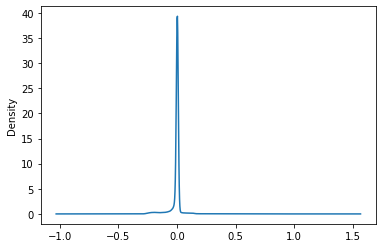

In [343]:
train_sub['pca_3'].plot(kind='kde')

In [345]:
train_sub.head()

,num_var4,num_var35,num_meses_var5_ult3,num_var30,ind_var30,saldo_var30,var15,ind_var13,saldo_medio_var5_ult1,saldo_medio_var5_hace2,var38,saldo_var42,ind_var12_0,num_var30_0,imp_op_var39_efect_ult1,imp_op_var41_efect_ult1,ind_var30_0,imp_op_var41_efect_ult3,num_var42_0,imp_op_var39_efect_ult3,ind_var8_0,saldo_medio_var5_hace3,imp_op_var39_ult1,ind_var8,saldo_var5,imp_op_var40_efect_ult3,saldo_medio_var5_ult3,num_var8_0,num_var45_hace3,var3,num_var45_ult1,imp_op_var40_efect_ult1,num_var22_ult1,num_var37_med_ult2,num_med_var45_ult3,saldo_var8,saldo_var37,num_var5_0,saldo_medio_var8_ult3,saldo_medio_var8_ult1,num_var37_0,ID,num_var22_ult3,num_op_var41_efect_ult3,num_var22_hace3,ind_var37,num_med_var22_ult3,num_op_var39_ult3,num_var37,num_op_var41_efect_ult1,num_op_var39_efect_ult1,num_var45_ult3,imp_op_var41_comer_ult3,imp_op_var41_comer_ult1,imp_op_var39_comer_ult1,num_var22_hace2,imp_sal_var16_ult1,TARGET,n_zeros,pca_1,pca_2,pca_3
0,0,0,0,0,0,0.00,23,0,0.00,0.00,39205.170000,0.00,0,3,0.0,0.0,1,0.0,3,0.0,0,0.00,0.0,0,0.00,0.0,0.00,0,0,2,0,0.0,0,0,0,0.0,0.00,3,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0,50,0.679914,0.308059,0.338259
1,1,3,1,3,1,300.00,34,1,0.00,0.00,49278.030000,0.00,0,6,0.0,0.0,1,0.0,3,0.0,0,88.89,0.0,0,0.00,0.0,0.00,0,0,2,0,0.0,0,0,0,0.0,0.00,3,0.0,0.0,0,3,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0,42,1.303495,-0.220429,0.149846
2,1,3,3,3,1,3.00,23,0,3.00,3.00,67333.770000,3.00,0,3,0.0,0.0,1,0.0,3,0.0,0,0.18,0.0,0,3.00,0.0,2.07,0,0,2,0,0.0,0,0,0,0.0,0.00,3,0.0,0.0,0,4,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0,38,0.666864,0.338269,0.302952
3,3,9,2,3,1,70.62,37,0,91.56,186.09,64007.970000,70.62,0,3,0.0,0.0,1,0.0,3,0.0,0,0.00,195.0,0,70.62,0.0,138.84,0,3,2,18,0.0,0,6,15,0.0,34.95,3,0.0,0.0,6,8,3,0,0,1,0,9,6,0,0,48,195.0,195.0,195.0,3,0.0,0,23,0.758142,0.695493,0.107785
4,1,3,3,3,1,135003.00,39,0,40501.08,3.00,117310.979016,135003.00,1,6,0.0,0.0,1,0.0,6,0.0,0,0.30,0.0,0,0.00,0.0,13501.47,0,0,2,0,0.0,6,0,0,0.0,0.00,3,0.0,0.0,0,10,9,0,0,0,3,0,0,0,0,0,0.0,0.0,0.0,3,0.0,0,34,0.769264,0.777326,0.028185


In [ ]:
sns.relplot(x="num_var4")

In [349]:
train_sub.loc[:, selected_feats_xgb[:10]]

,num_var4,num_var35,num_meses_var5_ult3,num_var30,ind_var30,saldo_var30,var15,ind_var13,saldo_medio_var5_ult1,saldo_medio_var5_hace2
0,0,0,0,0,0,0.00,23,0,0.00,0.00
1,1,3,1,3,1,300.00,34,1,0.00,0.00
2,1,3,3,3,1,3.00,23,0,3.00,3.00
3,3,9,2,3,1,70.62,37,0,91.56,186.09
4,1,3,3,3,1,135003.00,39,0,40501.08,3.00
5,0,0,0,0,0,0.00,23,0,0.00,0.00
6,1,3,3,3,1,3.00,27,0,3.00,3.00
7,1,3,2,3,1,3.00,26,0,3.00,2.88
8,0,0,0,0,0,0.00,45,0,0.00,0.00
9,1,3,2,3,1,3.00,25,0,3.00,2.79


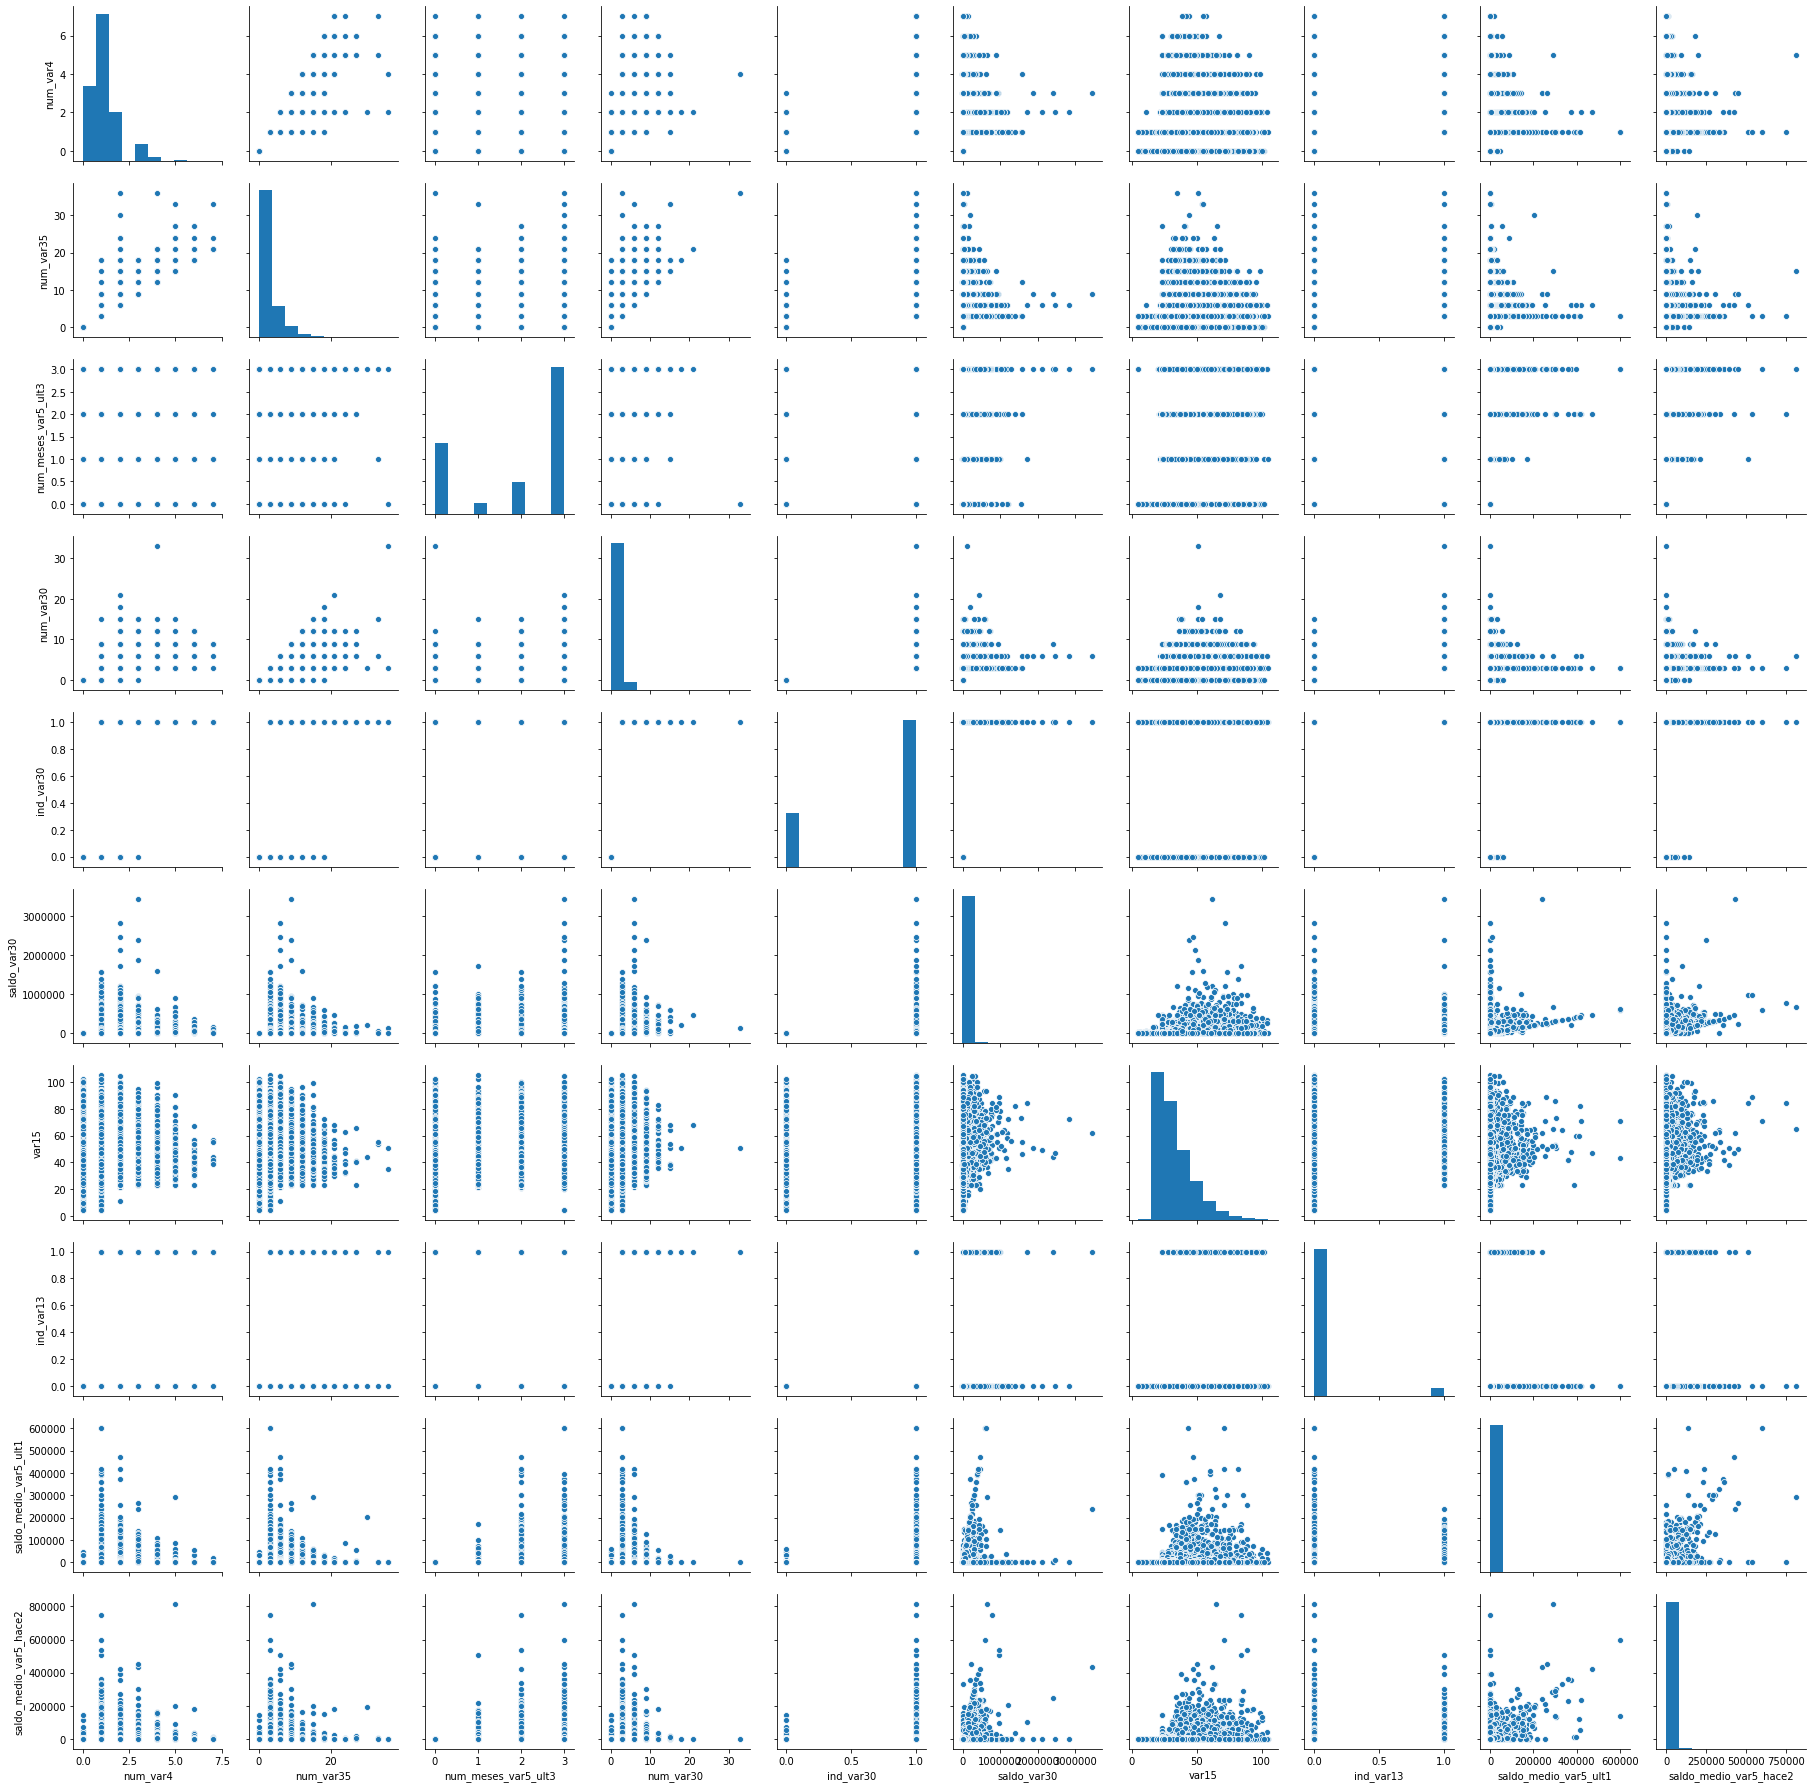

In [350]:
sns.pairplot(train_sub.loc[:, selected_feats_xgb[:10]])

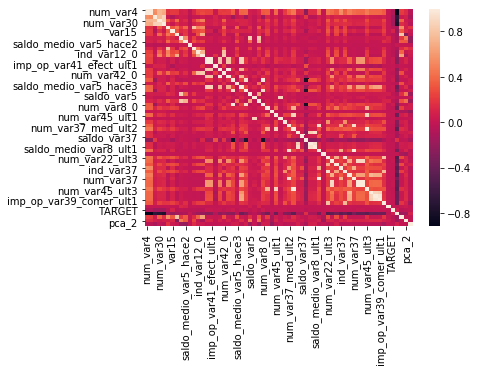

In [351]:
sns.heatmap(train_sub.corr())

In [370]:
from sklearn.cluster.bicluster import SpectralBiclustering, SpectralCoclustering
spec_model = SpectralCoclustering(n_clusters=15, n_jobs=-1, random_state=10)

In [371]:
corr_data = train_sub.corr()
rows_ids = corr_data.index
corr_data_np = corr_data.to_numpy()
spec_model.fit(corr_data)
fit_data = corr_data_np[np.argsort(spec_model.row_labels_)]
fit_data = fit_data[:, np.argsort(spec_model.column_labels_)]
fit_data_df = pd.DataFrame(fit_data, index=rows_ids[np.argsort(spec_model.row_labels_)], columns=rows_ids[np.argsort(spec_model.row_labels_)])


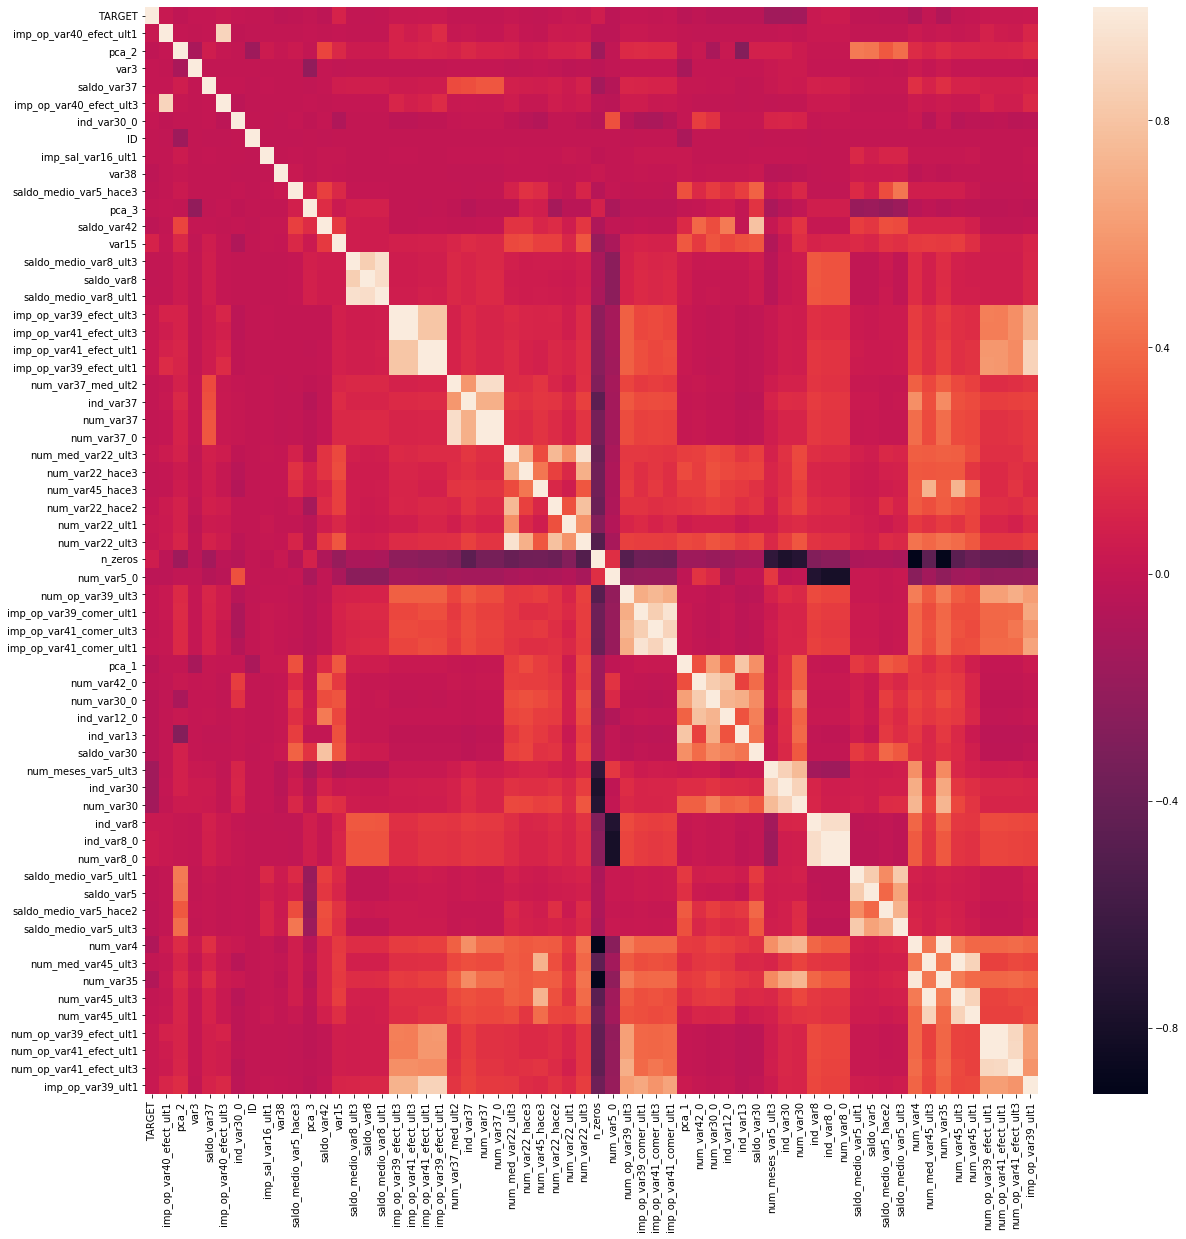

In [374]:
plt.figure(figsize=(20, 20))
ax = plt.gca()
sns.heatmap(fit_data_df, ax=ax)

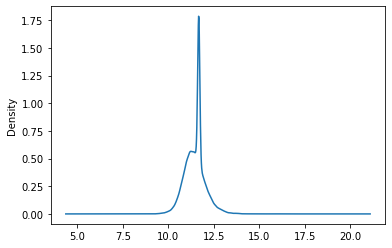

In [427]:
train_sub_x['var38'].apply(lambda x: np.log(x)).plot(kind='kde')

In [ ]:
train_sub_x["var8_new2"] = (train_sub_x["num_var8_0"] + train_sub_x["ind_var8_0"] + train_sub_x["ind_var8"])

In [428]:
train_sub_x['var38'] = np.log(train_sub_x['var38'])
test_sub['var38'] = np.log(test_sub['var38'])

In [418]:
train_sub_x["var8_new1"] = (train_sub_x["num_var8_0"]*100 + train_sub_x["ind_var8_0"]*10 + train_sub_x["ind_var8"])

In [410]:
test_sub["var8_new1"] = (test_sub["num_var8_0"]*100 + test_sub["ind_var8_0"]*10 + test_sub["ind_var8"])

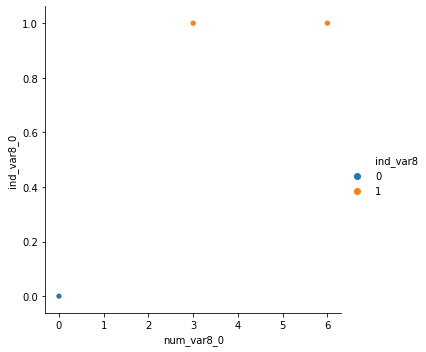

In [377]:
sns.relplot(x="num_var8_0", y="ind_var8_0", hue="ind_var8", data=train_sub)

In [344]:
import seaborn as sns

In [ ]:
sns.relplot(x="pca_")

In [8]:
# train.drop(feats_to_delete, axis=1, inplace=True)

In [172]:
from sklearn.model_selection import StratifiedKFold

In [385]:
skf = StratifiedKFold(n_splits=15, random_state=22)

In [384]:
param = {'max_depth': 3, 'eta': 0.1, 'silent': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'
param['colsample_bytree'] = 0.7

In [ ]:
test_sub = test.

In [190]:
x_oov = xgb.DMatrix(test_transform_pca)

train_transform_pca_x = train_transform_pca.drop(['TARGET'], axis=1)
train_transform_pca_y = train_transform_pca['TARGET']

all_preds = None
for train_index, test_index in skf.split(train_transform_pca_x, train_transform_pca_y):
    x_train, x_test = train_transform_pca_x.iloc[train_index], train_transform_pca_x.iloc[test_index]
    y_train, y_test = train_transform_pca_y.iloc[train_index], train_transform_pca_y.iloc[test_index]
    
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dtest = xgb.DMatrix(x_test, label=y_test)
    evallist = [(dtest, 'eval'), (dtrain, 'train')]
    num_round = 130
    model = xgb.XGBClassifier()
    bst = model.train(param, dtrain, num_round, evallist)
    
    preds = bst.predict(x_oov)
    if all_preds is None:
        all_preds = preds
    else:
        all_preds *= preds
    
    

/Users/santoshgsk/Desktop/Code/venv/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	eval-auc:0.797365	train-auc:0.794691
[1]	eval-auc:0.769316	train-auc:0.788923
[2]	eval-auc:0.421084	train-auc:0.797119
[3]	eval-auc:0.432573	train-auc:0.807476
[4]	eval-auc:0.441148	train-auc:0.810264
[5]	eval-auc:0.504728	train-auc:0.816751
[6]	eval-auc:0.68211	train-auc:0.819869
[7]	eval-auc:0.461936	train-auc:0.814956
[8]	eval-auc:0.43694	train-auc:0.814791
[9]	eval-auc:0.43608	train-auc:0.813893
[10]	eval-auc:0.439006	train-auc:0.81504
[11]	eval-auc:0.440786	train-auc:0.816142
[12]	eval-auc:0.441799	train-auc:0.817119
[13]	eval-auc:0.444233	train-auc:0.822449
[14]	eval-auc:0.446562	train-auc:0.823363
[15]	eval-auc:0.452944	train-auc:0.823906
[16]	eval-auc:0.467475	train-auc:0.825688
[17]	eval-auc:0.540625	train-auc:0.825757
[18]	eval-auc:0.454809	train-auc:0.825477
[19]	eval-auc:0.458718	train-auc:0.826873
[20]	eval-auc:0.482138	train-auc:0.828172
[21]	eval-auc:0.521603	train-auc:0.828604
[22]	eval-auc:0.578084	train-auc:0.830907
[23]	eval-auc:0.644424	train-auc:0.83126
[24]	ev

[66]	eval-auc:0.822916	train-auc:0.851168
[67]	eval-auc:0.823209	train-auc:0.851327
[68]	eval-auc:0.823304	train-auc:0.851637
[69]	eval-auc:0.82337	train-auc:0.851836
[70]	eval-auc:0.823655	train-auc:0.852123
[71]	eval-auc:0.823909	train-auc:0.852501
[72]	eval-auc:0.824165	train-auc:0.852776
[73]	eval-auc:0.824338	train-auc:0.852914
[74]	eval-auc:0.823844	train-auc:0.853165
[75]	eval-auc:0.824084	train-auc:0.853321
[76]	eval-auc:0.82402	train-auc:0.853608
[77]	eval-auc:0.82384	train-auc:0.85387
[78]	eval-auc:0.823839	train-auc:0.854086
[79]	eval-auc:0.823277	train-auc:0.854237
[80]	eval-auc:0.823279	train-auc:0.854449
[81]	eval-auc:0.823679	train-auc:0.854583
[82]	eval-auc:0.823893	train-auc:0.854715
[83]	eval-auc:0.823601	train-auc:0.855057
[84]	eval-auc:0.823701	train-auc:0.855282
[85]	eval-auc:0.823442	train-auc:0.85557
[86]	eval-auc:0.823452	train-auc:0.855747
[87]	eval-auc:0.823484	train-auc:0.85588
[88]	eval-auc:0.823561	train-auc:0.85601
[89]	eval-auc:0.823337	train-auc:0.856215

[1]	eval-auc:0.749594	train-auc:0.792493
[2]	eval-auc:0.758805	train-auc:0.80182
[3]	eval-auc:0.767778	train-auc:0.812491
[4]	eval-auc:0.771267	train-auc:0.818396
[5]	eval-auc:0.773152	train-auc:0.821426
[6]	eval-auc:0.776759	train-auc:0.822345
[7]	eval-auc:0.778252	train-auc:0.821829
[8]	eval-auc:0.777265	train-auc:0.819269
[9]	eval-auc:0.775691	train-auc:0.81846
[10]	eval-auc:0.776159	train-auc:0.819743
[11]	eval-auc:0.777074	train-auc:0.820979
[12]	eval-auc:0.777736	train-auc:0.824946
[13]	eval-auc:0.778225	train-auc:0.827327
[14]	eval-auc:0.77859	train-auc:0.827833
[15]	eval-auc:0.784173	train-auc:0.829972
[16]	eval-auc:0.778555	train-auc:0.829271
[17]	eval-auc:0.782394	train-auc:0.830605
[18]	eval-auc:0.78503	train-auc:0.830972
[19]	eval-auc:0.780833	train-auc:0.830632
[20]	eval-auc:0.781874	train-auc:0.832592
[21]	eval-auc:0.780847	train-auc:0.831952
[22]	eval-auc:0.783594	train-auc:0.833908
[23]	eval-auc:0.786198	train-auc:0.834683
[24]	eval-auc:0.788381	train-auc:0.834994
[25]	

[67]	eval-auc:0.853652	train-auc:0.849721
[68]	eval-auc:0.853585	train-auc:0.850094
[69]	eval-auc:0.853343	train-auc:0.850285
[70]	eval-auc:0.853528	train-auc:0.850394
[71]	eval-auc:0.853484	train-auc:0.850514
[72]	eval-auc:0.853664	train-auc:0.850613
[73]	eval-auc:0.854304	train-auc:0.851082
[74]	eval-auc:0.854339	train-auc:0.851295
[75]	eval-auc:0.854107	train-auc:0.851618
[76]	eval-auc:0.853793	train-auc:0.851799
[77]	eval-auc:0.85404	train-auc:0.852018
[78]	eval-auc:0.853911	train-auc:0.852226
[79]	eval-auc:0.854014	train-auc:0.85234
[80]	eval-auc:0.853964	train-auc:0.852551
[81]	eval-auc:0.853955	train-auc:0.852725
[82]	eval-auc:0.85396	train-auc:0.852897
[83]	eval-auc:0.854238	train-auc:0.853196
[84]	eval-auc:0.854415	train-auc:0.853348
[85]	eval-auc:0.854555	train-auc:0.853701
[86]	eval-auc:0.85428	train-auc:0.853761
[87]	eval-auc:0.854142	train-auc:0.853923
[88]	eval-auc:0.853977	train-auc:0.854015
[89]	eval-auc:0.853953	train-auc:0.854115
[90]	eval-auc:0.853922	train-auc:0.854

[3]	eval-auc:0.820347	train-auc:0.809938
[4]	eval-auc:0.826919	train-auc:0.815716
[5]	eval-auc:0.827858	train-auc:0.820855
[6]	eval-auc:0.828135	train-auc:0.823711
[7]	eval-auc:0.833985	train-auc:0.821085
[8]	eval-auc:0.829184	train-auc:0.81861
[9]	eval-auc:0.826743	train-auc:0.817527
[10]	eval-auc:0.826963	train-auc:0.819193
[11]	eval-auc:0.830055	train-auc:0.821966
[12]	eval-auc:0.831333	train-auc:0.823667
[13]	eval-auc:0.830023	train-auc:0.825226
[14]	eval-auc:0.82875	train-auc:0.825745
[15]	eval-auc:0.830315	train-auc:0.82697
[16]	eval-auc:0.834201	train-auc:0.829696
[17]	eval-auc:0.833969	train-auc:0.829361
[18]	eval-auc:0.835084	train-auc:0.829728
[19]	eval-auc:0.835379	train-auc:0.828695
[20]	eval-auc:0.836248	train-auc:0.830944
[21]	eval-auc:0.836084	train-auc:0.830382
[22]	eval-auc:0.838226	train-auc:0.832581
[23]	eval-auc:0.838376	train-auc:0.833479
[24]	eval-auc:0.838306	train-auc:0.833278
[25]	eval-auc:0.838551	train-auc:0.833912
[26]	eval-auc:0.837801	train-auc:0.834459
[2

[69]	eval-auc:0.851212	train-auc:0.849935
[70]	eval-auc:0.851845	train-auc:0.850424
[71]	eval-auc:0.851842	train-auc:0.85054
[72]	eval-auc:0.85259	train-auc:0.850803
[73]	eval-auc:0.852516	train-auc:0.85104
[74]	eval-auc:0.852698	train-auc:0.851158
[75]	eval-auc:0.852768	train-auc:0.851528
[76]	eval-auc:0.8528	train-auc:0.851728
[77]	eval-auc:0.853189	train-auc:0.851868
[78]	eval-auc:0.853486	train-auc:0.85217
[79]	eval-auc:0.853676	train-auc:0.852336
[80]	eval-auc:0.853829	train-auc:0.85254
[81]	eval-auc:0.854006	train-auc:0.85269
[82]	eval-auc:0.854175	train-auc:0.852789
[83]	eval-auc:0.854451	train-auc:0.853007
[84]	eval-auc:0.854473	train-auc:0.85319
[85]	eval-auc:0.854589	train-auc:0.853308
[86]	eval-auc:0.854455	train-auc:0.853479
[87]	eval-auc:0.854483	train-auc:0.853671
[88]	eval-auc:0.85465	train-auc:0.853875
[89]	eval-auc:0.855047	train-auc:0.85399
[90]	eval-auc:0.855031	train-auc:0.854151
[91]	eval-auc:0.854776	train-auc:0.854291
[92]	eval-auc:0.854762	train-auc:0.854449
[93

[5]	eval-auc:0.810919	train-auc:0.821138
[6]	eval-auc:0.81269	train-auc:0.822832
[7]	eval-auc:0.809893	train-auc:0.818014
[8]	eval-auc:0.810603	train-auc:0.818331
[9]	eval-auc:0.811626	train-auc:0.817425
[10]	eval-auc:0.812516	train-auc:0.81837
[11]	eval-auc:0.813186	train-auc:0.819702
[12]	eval-auc:0.818216	train-auc:0.823827
[13]	eval-auc:0.820261	train-auc:0.824516
[14]	eval-auc:0.820642	train-auc:0.825293
[15]	eval-auc:0.822808	train-auc:0.827606
[16]	eval-auc:0.823062	train-auc:0.827602
[17]	eval-auc:0.825855	train-auc:0.827772
[18]	eval-auc:0.825542	train-auc:0.828229
[19]	eval-auc:0.824389	train-auc:0.826058
[20]	eval-auc:0.825354	train-auc:0.829021
[21]	eval-auc:0.825909	train-auc:0.828205
[22]	eval-auc:0.82822	train-auc:0.830749
[23]	eval-auc:0.82962	train-auc:0.832074
[24]	eval-auc:0.828932	train-auc:0.832271
[25]	eval-auc:0.829708	train-auc:0.832861
[26]	eval-auc:0.829175	train-auc:0.833372
[27]	eval-auc:0.829716	train-auc:0.834085
[28]	eval-auc:0.829577	train-auc:0.83484
[2

[71]	eval-auc:0.867353	train-auc:0.849764
[72]	eval-auc:0.867275	train-auc:0.849881
[73]	eval-auc:0.867471	train-auc:0.850171
[74]	eval-auc:0.86772	train-auc:0.850374
[75]	eval-auc:0.867646	train-auc:0.850678
[76]	eval-auc:0.86747	train-auc:0.851057
[77]	eval-auc:0.867477	train-auc:0.851397
[78]	eval-auc:0.867546	train-auc:0.851601
[79]	eval-auc:0.867525	train-auc:0.851647
[80]	eval-auc:0.867435	train-auc:0.851737
[81]	eval-auc:0.867378	train-auc:0.851892
[82]	eval-auc:0.867209	train-auc:0.852007
[83]	eval-auc:0.867155	train-auc:0.852138
[84]	eval-auc:0.867108	train-auc:0.852249
[85]	eval-auc:0.867331	train-auc:0.852393
[86]	eval-auc:0.86744	train-auc:0.852519
[87]	eval-auc:0.867435	train-auc:0.852772
[88]	eval-auc:0.867456	train-auc:0.852915
[89]	eval-auc:0.867408	train-auc:0.853188
[90]	eval-auc:0.867166	train-auc:0.853292
[91]	eval-auc:0.867412	train-auc:0.853467
[92]	eval-auc:0.867338	train-auc:0.853582
[93]	eval-auc:0.86727	train-auc:0.85389
[94]	eval-auc:0.867279	train-auc:0.8539

[7]	eval-auc:0.827424	train-auc:0.814915
[8]	eval-auc:0.827262	train-auc:0.815097
[9]	eval-auc:0.828641	train-auc:0.814533
[10]	eval-auc:0.831026	train-auc:0.817263
[11]	eval-auc:0.832221	train-auc:0.817891
[12]	eval-auc:0.837186	train-auc:0.824166
[13]	eval-auc:0.837587	train-auc:0.824851
[14]	eval-auc:0.838541	train-auc:0.82647
[15]	eval-auc:0.840114	train-auc:0.826896
[16]	eval-auc:0.838696	train-auc:0.828723
[17]	eval-auc:0.838553	train-auc:0.828656
[18]	eval-auc:0.840953	train-auc:0.828891
[19]	eval-auc:0.840213	train-auc:0.827968
[20]	eval-auc:0.841512	train-auc:0.82905
[21]	eval-auc:0.84209	train-auc:0.828576
[22]	eval-auc:0.843784	train-auc:0.830213
[23]	eval-auc:0.843988	train-auc:0.830475
[24]	eval-auc:0.844833	train-auc:0.830686
[25]	eval-auc:0.844245	train-auc:0.831104
[26]	eval-auc:0.844586	train-auc:0.831841
[27]	eval-auc:0.844824	train-auc:0.832833
[28]	eval-auc:0.845649	train-auc:0.83299
[29]	eval-auc:0.846048	train-auc:0.833717
[30]	eval-auc:0.845725	train-auc:0.834523

[73]	eval-auc:0.832527	train-auc:0.852167
[74]	eval-auc:0.832422	train-auc:0.852372
[75]	eval-auc:0.832466	train-auc:0.852652
[76]	eval-auc:0.832695	train-auc:0.852953
[77]	eval-auc:0.832401	train-auc:0.853339
[78]	eval-auc:0.832346	train-auc:0.853671
[79]	eval-auc:0.832349	train-auc:0.853703
[80]	eval-auc:0.832367	train-auc:0.853841
[81]	eval-auc:0.832421	train-auc:0.854016
[82]	eval-auc:0.832429	train-auc:0.854236
[83]	eval-auc:0.832346	train-auc:0.854471
[84]	eval-auc:0.832371	train-auc:0.854566
[85]	eval-auc:0.832729	train-auc:0.8548
[86]	eval-auc:0.83281	train-auc:0.854981
[87]	eval-auc:0.832837	train-auc:0.855176
[88]	eval-auc:0.832769	train-auc:0.855388
[89]	eval-auc:0.832386	train-auc:0.855569
[90]	eval-auc:0.832349	train-auc:0.85563
[91]	eval-auc:0.832298	train-auc:0.855813
[92]	eval-auc:0.832448	train-auc:0.855938
[93]	eval-auc:0.832359	train-auc:0.85603
[94]	eval-auc:0.832334	train-auc:0.856172
[95]	eval-auc:0.832456	train-auc:0.856296
[96]	eval-auc:0.832548	train-auc:0.8563

In [386]:
train_x = train_sub.drop(['TARGET'], axis=1)
train_y = train_sub['TARGET']

In [413]:
len(train_sub_x.columns)

61

In [419]:
train_sub_x.columns

Index(['num_var4', 'num_var35', 'num_meses_var5_ult3', 'num_var30',
       'ind_var30', 'saldo_var30', 'var15', 'ind_var13',
       'saldo_medio_var5_ult1', 'saldo_medio_var5_hace2', 'var38',
       'saldo_var42', 'ind_var12_0', 'num_var30_0', 'imp_op_var39_efect_ult1',
       'imp_op_var41_efect_ult1', 'ind_var30_0', 'imp_op_var41_efect_ult3',
       'num_var42_0', 'imp_op_var39_efect_ult3', 'ind_var8_0',
       'saldo_medio_var5_hace3', 'imp_op_var39_ult1', 'ind_var8', 'saldo_var5',
       'imp_op_var40_efect_ult3', 'saldo_medio_var5_ult3', 'num_var8_0',
       'num_var45_hace3', 'var3', 'num_var45_ult1', 'imp_op_var40_efect_ult1',
       'num_var22_ult1', 'num_var37_med_ult2', 'num_med_var45_ult3',
       'saldo_var8', 'saldo_var37', 'num_var5_0', 'saldo_medio_var8_ult3',
       'saldo_medio_var8_ult1', 'num_var37_0', 'ID', 'num_var22_ult3',
       'num_op_var41_efect_ult3', 'num_var22_hace3', 'ind_var37',
       'num_med_var22_ult3', 'num_op_var39_ult3', 'num_var37',
       'num_op

In [414]:
len(test_sub.columns)

62

In [416]:
test_sub.columns

Index(['num_var4', 'num_var35', 'num_meses_var5_ult3', 'num_var30',
       'ind_var30', 'saldo_var30', 'var15', 'ind_var13',
       'saldo_medio_var5_ult1', 'saldo_medio_var5_hace2', 'var38',
       'saldo_var42', 'ind_var12_0', 'num_var30_0', 'imp_op_var39_efect_ult1',
       'imp_op_var41_efect_ult1', 'ind_var30_0', 'imp_op_var41_efect_ult3',
       'num_var42_0', 'imp_op_var39_efect_ult3', 'ind_var8_0',
       'saldo_medio_var5_hace3', 'imp_op_var39_ult1', 'ind_var8', 'saldo_var5',
       'imp_op_var40_efect_ult3', 'saldo_medio_var5_ult3', 'num_var8_0',
       'num_var45_hace3', 'var3', 'num_var45_ult1', 'imp_op_var40_efect_ult1',
       'num_var22_ult1', 'num_var37_med_ult2', 'num_med_var45_ult3',
       'saldo_var8', 'saldo_var37', 'num_var5_0', 'saldo_medio_var8_ult3',
       'saldo_medio_var8_ult1', 'num_var37_0', 'ID', 'num_var22_ult3',
       'num_op_var41_efect_ult3', 'num_var22_hace3', 'ind_var37',
       'num_med_var22_ult3', 'num_op_var39_ult3', 'num_var37',
       'num_op

In [429]:
x_oov = xgb.DMatrix(test_sub)
all_preds = None
for train_index, test_index in skf.split(train_sub_x, train_y):
    x_train, x_test = train_sub_x.iloc[train_index], train_sub_x.iloc[test_index]
    y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
    
    dtrain = xgb.DMatrix(x_train, label=y_train) 
    dtest = xgb.DMatrix(x_test, label=y_test)
    evallist = [(dtest, 'eval'), (dtrain, 'train')]
    num_round = 130
    bst = xgb.train(param, dtrain, num_round, evallist)
    
    preds = bst.predict(x_oov)
    if all_preds is None:
        all_preds = preds
    else:
        all_preds *= preds
    
    

/Users/santoshgsk/Desktop/Code/venv/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	eval-auc:0.786555	train-auc:0.781849
[1]	eval-auc:0.417613	train-auc:0.781669
[2]	eval-auc:0.427951	train-auc:0.792575
[3]	eval-auc:0.441991	train-auc:0.811296
[4]	eval-auc:0.449033	train-auc:0.817585
[5]	eval-auc:0.418097	train-auc:0.808011
[6]	eval-auc:0.430749	train-auc:0.817171
[7]	eval-auc:0.555673	train-auc:0.822013
[8]	eval-auc:0.556353	train-auc:0.82282
[9]	eval-auc:0.624579	train-auc:0.823901
[10]	eval-auc:0.661495	train-auc:0.825978
[11]	eval-auc:0.452442	train-auc:0.824535
[12]	eval-auc:0.500204	train-auc:0.824694
[13]	eval-auc:0.562674	train-auc:0.825208
[14]	eval-auc:0.446646	train-auc:0.818517
[15]	eval-auc:0.45108	train-auc:0.823628
[16]	eval-auc:0.487769	train-auc:0.824369
[17]	eval-auc:0.519915	train-auc:0.822111
[18]	eval-auc:0.57636	train-auc:0.82656
[19]	eval-auc:0.625256	train-auc:0.828849
[20]	eval-auc:0.661804	train-auc:0.829093
[21]	eval-auc:0.695048	train-auc:0.829883
[22]	eval-auc:0.719044	train-auc:0.831383
[23]	eval-auc:0.736013	train-auc:0.831862
[24]	e

[67]	eval-auc:0.820974	train-auc:0.851708
[68]	eval-auc:0.820934	train-auc:0.851915
[69]	eval-auc:0.820707	train-auc:0.852112
[70]	eval-auc:0.82093	train-auc:0.852395
[71]	eval-auc:0.820549	train-auc:0.852509
[72]	eval-auc:0.820606	train-auc:0.852649
[73]	eval-auc:0.820712	train-auc:0.852816
[74]	eval-auc:0.820621	train-auc:0.852974
[75]	eval-auc:0.820804	train-auc:0.853118
[76]	eval-auc:0.82099	train-auc:0.853306
[77]	eval-auc:0.821556	train-auc:0.853519
[78]	eval-auc:0.821754	train-auc:0.85371
[79]	eval-auc:0.821835	train-auc:0.853832
[80]	eval-auc:0.821652	train-auc:0.853981
[81]	eval-auc:0.821649	train-auc:0.854163
[82]	eval-auc:0.82185	train-auc:0.85431
[83]	eval-auc:0.821734	train-auc:0.854403
[84]	eval-auc:0.821717	train-auc:0.854589
[85]	eval-auc:0.821772	train-auc:0.854831
[86]	eval-auc:0.821745	train-auc:0.855023
[87]	eval-auc:0.821836	train-auc:0.855367
[88]	eval-auc:0.82179	train-auc:0.855404
[89]	eval-auc:0.821789	train-auc:0.855579
[90]	eval-auc:0.821832	train-auc:0.85574

[2]	eval-auc:0.756026	train-auc:0.804288
[3]	eval-auc:0.770764	train-auc:0.816593
[4]	eval-auc:0.773953	train-auc:0.82107
[5]	eval-auc:0.771587	train-auc:0.814695
[6]	eval-auc:0.777242	train-auc:0.821867
[7]	eval-auc:0.777967	train-auc:0.822052
[8]	eval-auc:0.782221	train-auc:0.824675
[9]	eval-auc:0.77972	train-auc:0.824765
[10]	eval-auc:0.78542	train-auc:0.825683
[11]	eval-auc:0.788629	train-auc:0.826599
[12]	eval-auc:0.78527	train-auc:0.826832
[13]	eval-auc:0.782733	train-auc:0.825038
[14]	eval-auc:0.778735	train-auc:0.819937
[15]	eval-auc:0.780802	train-auc:0.824242
[16]	eval-auc:0.78181	train-auc:0.826817
[17]	eval-auc:0.779962	train-auc:0.824517
[18]	eval-auc:0.783009	train-auc:0.828226
[19]	eval-auc:0.787174	train-auc:0.830325
[20]	eval-auc:0.788386	train-auc:0.832293
[21]	eval-auc:0.788933	train-auc:0.833558
[22]	eval-auc:0.790226	train-auc:0.833951
[23]	eval-auc:0.790802	train-auc:0.834311
[24]	eval-auc:0.790872	train-auc:0.834299
[25]	eval-auc:0.792761	train-auc:0.835173
[26]	

[68]	eval-auc:0.853688	train-auc:0.850029
[69]	eval-auc:0.854069	train-auc:0.850209
[70]	eval-auc:0.854088	train-auc:0.850562
[71]	eval-auc:0.853958	train-auc:0.850749
[72]	eval-auc:0.854207	train-auc:0.850916
[73]	eval-auc:0.854243	train-auc:0.85112
[74]	eval-auc:0.854069	train-auc:0.851429
[75]	eval-auc:0.854333	train-auc:0.851648
[76]	eval-auc:0.854275	train-auc:0.851761
[77]	eval-auc:0.854095	train-auc:0.852048
[78]	eval-auc:0.854052	train-auc:0.852209
[79]	eval-auc:0.854105	train-auc:0.852302
[80]	eval-auc:0.854219	train-auc:0.852412
[81]	eval-auc:0.854504	train-auc:0.852607
[82]	eval-auc:0.854432	train-auc:0.852885
[83]	eval-auc:0.854214	train-auc:0.853015
[84]	eval-auc:0.854121	train-auc:0.85319
[85]	eval-auc:0.854185	train-auc:0.853281
[86]	eval-auc:0.854094	train-auc:0.853355
[87]	eval-auc:0.854169	train-auc:0.853596
[88]	eval-auc:0.854113	train-auc:0.853771
[89]	eval-auc:0.854139	train-auc:0.853938
[90]	eval-auc:0.839637	train-auc:0.854897
[91]	eval-auc:0.839878	train-auc:0.8

[3]	eval-auc:0.824529	train-auc:0.820425
[4]	eval-auc:0.829998	train-auc:0.823009
[5]	eval-auc:0.832132	train-auc:0.818604
[6]	eval-auc:0.831729	train-auc:0.821902
[7]	eval-auc:0.831816	train-auc:0.825379
[8]	eval-auc:0.830772	train-auc:0.825773
[9]	eval-auc:0.830921	train-auc:0.826217
[10]	eval-auc:0.829401	train-auc:0.827099
[11]	eval-auc:0.83079	train-auc:0.827802
[12]	eval-auc:0.831006	train-auc:0.827575
[13]	eval-auc:0.831033	train-auc:0.826332
[14]	eval-auc:0.827685	train-auc:0.821368
[15]	eval-auc:0.830203	train-auc:0.824097
[16]	eval-auc:0.830229	train-auc:0.825246
[17]	eval-auc:0.828036	train-auc:0.823892
[18]	eval-auc:0.832248	train-auc:0.82828
[19]	eval-auc:0.833377	train-auc:0.829383
[20]	eval-auc:0.834472	train-auc:0.830272
[21]	eval-auc:0.836023	train-auc:0.83138
[22]	eval-auc:0.835067	train-auc:0.832684
[23]	eval-auc:0.835811	train-auc:0.832879
[24]	eval-auc:0.83642	train-auc:0.832918
[25]	eval-auc:0.837568	train-auc:0.834079
[26]	eval-auc:0.837225	train-auc:0.83421
[27]

[69]	eval-auc:0.854039	train-auc:0.850434
[70]	eval-auc:0.854285	train-auc:0.85063
[71]	eval-auc:0.85443	train-auc:0.850902
[72]	eval-auc:0.854647	train-auc:0.851204
[73]	eval-auc:0.855514	train-auc:0.851313
[74]	eval-auc:0.855334	train-auc:0.851578
[75]	eval-auc:0.855839	train-auc:0.851748
[76]	eval-auc:0.855775	train-auc:0.851987
[77]	eval-auc:0.855799	train-auc:0.852019
[78]	eval-auc:0.855851	train-auc:0.852151
[79]	eval-auc:0.855969	train-auc:0.852302
[80]	eval-auc:0.855973	train-auc:0.852375
[81]	eval-auc:0.856156	train-auc:0.852518
[82]	eval-auc:0.856088	train-auc:0.852822
[83]	eval-auc:0.856176	train-auc:0.852865
[84]	eval-auc:0.856274	train-auc:0.852974
[85]	eval-auc:0.856412	train-auc:0.853136
[86]	eval-auc:0.856559	train-auc:0.853217
[87]	eval-auc:0.856646	train-auc:0.853318
[88]	eval-auc:0.85669	train-auc:0.853388
[89]	eval-auc:0.85687	train-auc:0.853508
[90]	eval-auc:0.856878	train-auc:0.853675
[91]	eval-auc:0.857246	train-auc:0.853841
[92]	eval-auc:0.857291	train-auc:0.853

[5]	eval-auc:0.802797	train-auc:0.811413
[6]	eval-auc:0.810426	train-auc:0.817632
[7]	eval-auc:0.812366	train-auc:0.821086
[8]	eval-auc:0.814149	train-auc:0.821485
[9]	eval-auc:0.815123	train-auc:0.824302
[10]	eval-auc:0.815387	train-auc:0.824067
[11]	eval-auc:0.819026	train-auc:0.824555
[12]	eval-auc:0.818999	train-auc:0.824584
[13]	eval-auc:0.818637	train-auc:0.823949
[14]	eval-auc:0.812417	train-auc:0.818383
[15]	eval-auc:0.819506	train-auc:0.823238
[16]	eval-auc:0.82298	train-auc:0.826714
[17]	eval-auc:0.817672	train-auc:0.824013
[18]	eval-auc:0.823544	train-auc:0.827362
[19]	eval-auc:0.82357	train-auc:0.829096
[20]	eval-auc:0.825966	train-auc:0.830542
[21]	eval-auc:0.827486	train-auc:0.83178
[22]	eval-auc:0.827225	train-auc:0.832354
[23]	eval-auc:0.827258	train-auc:0.832661
[24]	eval-auc:0.827174	train-auc:0.832567
[25]	eval-auc:0.829595	train-auc:0.833565
[26]	eval-auc:0.830084	train-auc:0.833397
[27]	eval-auc:0.830794	train-auc:0.83316
[28]	eval-auc:0.831009	train-auc:0.834408
[

[71]	eval-auc:0.867495	train-auc:0.850081
[72]	eval-auc:0.867276	train-auc:0.850367
[73]	eval-auc:0.866718	train-auc:0.850661
[74]	eval-auc:0.866842	train-auc:0.850807
[75]	eval-auc:0.866864	train-auc:0.850948
[76]	eval-auc:0.867023	train-auc:0.851052
[77]	eval-auc:0.866938	train-auc:0.851158
[78]	eval-auc:0.866748	train-auc:0.851363
[79]	eval-auc:0.866867	train-auc:0.851502
[80]	eval-auc:0.866972	train-auc:0.85165
[81]	eval-auc:0.86662	train-auc:0.85186
[82]	eval-auc:0.86657	train-auc:0.852129
[83]	eval-auc:0.86643	train-auc:0.852257
[84]	eval-auc:0.866286	train-auc:0.852457
[85]	eval-auc:0.866318	train-auc:0.852705
[86]	eval-auc:0.866224	train-auc:0.852872
[87]	eval-auc:0.866211	train-auc:0.852997
[88]	eval-auc:0.86634	train-auc:0.85315
[89]	eval-auc:0.8664	train-auc:0.853204
[90]	eval-auc:0.866426	train-auc:0.85336
[91]	eval-auc:0.866499	train-auc:0.853521
[92]	eval-auc:0.866416	train-auc:0.853605
[93]	eval-auc:0.866382	train-auc:0.853687
[94]	eval-auc:0.866247	train-auc:0.853875
[9

[7]	eval-auc:0.832277	train-auc:0.820689
[8]	eval-auc:0.83186	train-auc:0.820718
[9]	eval-auc:0.831263	train-auc:0.820581
[10]	eval-auc:0.833834	train-auc:0.822396
[11]	eval-auc:0.835562	train-auc:0.822512
[12]	eval-auc:0.834879	train-auc:0.822431
[13]	eval-auc:0.83696	train-auc:0.822434
[14]	eval-auc:0.832785	train-auc:0.817419
[15]	eval-auc:0.835085	train-auc:0.820879
[16]	eval-auc:0.839386	train-auc:0.825181
[17]	eval-auc:0.836343	train-auc:0.819872
[18]	eval-auc:0.840204	train-auc:0.82632
[19]	eval-auc:0.84125	train-auc:0.82876
[20]	eval-auc:0.841278	train-auc:0.8287
[21]	eval-auc:0.8411	train-auc:0.829471
[22]	eval-auc:0.84166	train-auc:0.829798
[23]	eval-auc:0.842873	train-auc:0.830214
[24]	eval-auc:0.8439	train-auc:0.831359
[25]	eval-auc:0.843923	train-auc:0.832153
[26]	eval-auc:0.844242	train-auc:0.831603
[27]	eval-auc:0.843806	train-auc:0.83191
[28]	eval-auc:0.844668	train-auc:0.833423
[29]	eval-auc:0.844292	train-auc:0.83361
[30]	eval-auc:0.845323	train-auc:0.834559
[31]	eval

[73]	eval-auc:0.831607	train-auc:0.852696
[74]	eval-auc:0.831703	train-auc:0.852923
[75]	eval-auc:0.831759	train-auc:0.853034
[76]	eval-auc:0.831425	train-auc:0.853327
[77]	eval-auc:0.831861	train-auc:0.853483
[78]	eval-auc:0.831994	train-auc:0.853783
[79]	eval-auc:0.832006	train-auc:0.854032
[80]	eval-auc:0.832115	train-auc:0.854202
[81]	eval-auc:0.8322	train-auc:0.854259
[82]	eval-auc:0.832274	train-auc:0.854485
[83]	eval-auc:0.832492	train-auc:0.854713
[84]	eval-auc:0.832186	train-auc:0.854876
[85]	eval-auc:0.832295	train-auc:0.854977
[86]	eval-auc:0.832358	train-auc:0.855043
[87]	eval-auc:0.832254	train-auc:0.855179
[88]	eval-auc:0.832167	train-auc:0.855339
[89]	eval-auc:0.832203	train-auc:0.855474
[90]	eval-auc:0.832167	train-auc:0.855563
[91]	eval-auc:0.832098	train-auc:0.855732
[92]	eval-auc:0.832076	train-auc:0.855829
[93]	eval-auc:0.832092	train-auc:0.856008
[94]	eval-auc:0.813276	train-auc:0.856875
[95]	eval-auc:0.813367	train-auc:0.856946
[96]	eval-auc:0.813501	train-auc:0.8

In [430]:
test_preds = all_preds**(1/15)

In [431]:
test["TARGET"] = test_preds

In [52]:
test[["ID", "TARGET"]].to_csv("test_preds_basic.csv", index=False)

In [193]:
test[["ID", "TARGET"]].to_csv("test_preds_pca_15fold_130rounds.csv", index=False)

In [423]:
test[["ID", "TARGET"]].to_csv("test_preds_var8_1_pca_15fold_100rounds.csv", index=False)

In [432]:
test[["ID", "TARGET"]].to_csv("test_preds_var8_1_logvar38_pca_15fold_100rounds.csv", index=False)

In [406]:
bst.g

AttributeError: 'Booster' object has no attribute 'g'

In [407]:
train_y = train['TARGET']
train_x = train.drop(['TARGET'], axis=1)

In [16]:
dtrain = xgb.DMatrix(train_x, label=train_y)

/Users/santoshgsk/Desktop/Code/venv/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/santoshgsk/Desktop/Code/venv/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
